In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from derm7pt.dataset import Derm7PtDataset, Derm7PtDatasetGroupInfrequent
from derm7pt.vis import plot_confusion
from derm7pt.kerasutils import deep_features
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm import tqdm
from keras.utils import np_utils
#import helpers


def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

        
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# CHANGE THIS LINE TO YOUR DATA DIRECTORY.
dir_release = os.path.join(ROOT_DIR, 'dataset/release_v0')
dir_meta = os.path.join(dir_release, 'meta')
dir_images = os.path.join(dir_release, 'images')

meta_df = pd.read_csv(os.path.join(dir_meta, 'meta.csv'))
train_indexes = list(pd.read_csv(os.path.join(dir_meta, 'train_indexes.csv'))['indexes'])
valid_indexes = list(pd.read_csv(os.path.join(dir_meta, 'valid_indexes.csv'))['indexes'])
test_indexes = list(pd.read_csv(os.path.join(dir_meta, 'test_indexes.csv'))['indexes'])

Using TensorFlow backend.


In [2]:
# The full dataset before any grouping of the labels.
derm_data = Derm7PtDataset(dir_images=dir_images, 
                        metadata_df=meta_df.copy(), # Copy as is modified.
                        train_indexes=train_indexes, valid_indexes=valid_indexes, 
                        test_indexes=test_indexes)

# The dataset after grouping infrequent labels.
derm_data_group = Derm7PtDatasetGroupInfrequent(dir_images=dir_images, 
                                             metadata_df=meta_df.copy(), # Copy as is modified.
                                             train_indexes=train_indexes, 
                                             valid_indexes=valid_indexes, 
                                             test_indexes=test_indexes)

In [5]:
derm_data.dataset_stats()

Number of cases: 1011
Number of cases to train: 413
Number of cases to validate: 203
Number of cases to test: 395


In [6]:
# Converted the meta-data to categorical (*_numeric) labels.
derm_data_group.df.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,...,case_id,notes,diagnosis_numeric,pigment_network_numeric,blue_whitish_veil_numeric,vascular_structures_numeric,pigmentation_numeric,streaks_numeric,dots_and_globules_numeric,regression_structures_numeric
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,...,NaN,NaN,0,0,0,1,0,0,0,0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,...,NaN,NaN,0,0,0,0,0,0,2,0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,...,NaN,NaN,0,0,0,1,0,0,2,0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,...,NaN,NaN,0,0,1,1,0,0,2,1
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,...,NaN,NaN,0,0,0,0,2,0,0,0


### TRAIN

In [7]:
# Get the dermatology and clinic training images and corresponding labels.
train_derm_paths = derm_data_group.get_img_paths(data_type='train', img_type='derm')
train_clinic_paths = derm_data_group.get_img_paths(data_type='train', img_type='clinic')
train_labels = derm_data_group.get_labels(data_type='train', one_hot=False)

### VAL

In [8]:
# Note, you can get images for validation by:
valid_derm_paths = derm_data_group.get_img_paths(data_type='valid', img_type='derm')
valid_clinic_paths = derm_data_group.get_img_paths(data_type='valid', img_type='clinic')
valid_labels = derm_data_group.get_labels(data_type='valid', one_hot=False)

## TEST

In [9]:
# Get the dermatology and clinic test images and corresponding labels.
test_derm_paths = derm_data_group.get_img_paths(data_type='test', img_type='derm')
test_clinic_paths = derm_data_group.get_img_paths(data_type='test', img_type='clinic')
test_labels = derm_data_group.get_labels(data_type='test', one_hot=False)

In [10]:
# Select one of the categories.
abbrev = 'DIAG'

# These are the labels associated with the given abbreviation.
label_names = derm_data_group.get_label_by_abbrev(abbrev).abbrevs.values
print(label_names)

['BCC' 'NEV' 'MEL' 'MISC' 'SK']


In [11]:
train_derm_paths[:3]
#import numpy as np
#np.count_nonzero(a == 0)

['/home/hasib/lesion-learnt/dataset/release_v0/images/NFL/Nfl068.jpg',
 '/home/hasib/lesion-learnt/dataset/release_v0/images/NGL/Ngl047.jpg',
 '/home/hasib/lesion-learnt/dataset/release_v0/images/NML/Nml106.jpg']

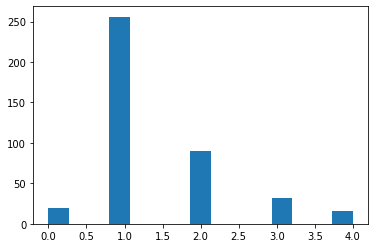

In [12]:
y_train = train_labels[abbrev].values
_ = plt.hist(y_train, bins='auto')
plt.show()

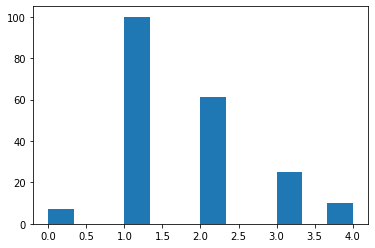

In [13]:
y_val = valid_labels[abbrev].values
_ = plt.hist(y_val, bins='auto')
plt.show()

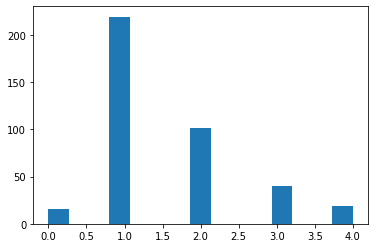

In [14]:
y_test = test_labels[abbrev].values
_ = plt.hist(y_test, bins='auto')
plt.show()

In [15]:
import cv2

#desired_size = 256
#im_pth = train_derm_paths[150]

#im = cv2.imread(im_pth)
#im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

def pad_img_cv2(im, desired_size=256):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_im


def pad_image_for_square( img ):
    (rows, cols, dim) = img.shape
    resize_dim = max( rows, cols)
    pad_row = resize_dim - rows
    pad_col = resize_dim - cols
    img = np.pad(img, ((0,pad_row), (0, pad_col), (0,0)), 'constant', constant_values=0)
    return img


def resize_img(img, resize_dim=256):
    img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img

def get_data(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=resize_img(img)
    return img

# one hot encoded vectors
#num_classes = 2
#g_t = np_utils.to_categorical(g_t,num_classes)


In [14]:
img = get_data(train_derm_paths[25])
img.shape

(256, 256, 3)

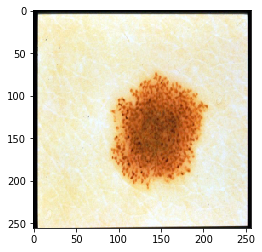

In [15]:
plt.imshow(img)

In [16]:
# first pad, then resize to keep aspect ratio
#plt.imshow(resize_img(pad_image_for_square(img)))

(256, 256, 3)


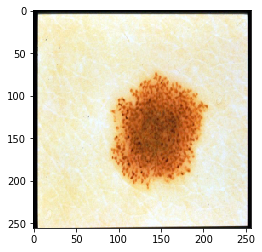

In [17]:
print(img.shape)
padded = pad_img_cv2(img)
plt.imshow(img)

(256, 256, 3)


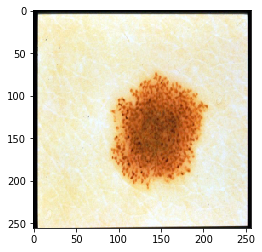

In [18]:
print(padded.shape)
plt.imshow(padded)

In [16]:
def load_data(paths, labels):
    images = []
    for path in tqdm(paths):
        images.append(get_data(path))
    
    images = np.array(images)
    num_classes = 5
    labels = labels["DIAG"].values
    labels = np_utils.to_categorical(labels, num_classes)
    return images, labels

In [17]:
# train data
x, y =load_data(train_derm_paths, train_labels)
x.shape, y.shape

100%|██████████| 413/413 [00:07<00:00, 52.87it/s]


((413, 256, 256, 3), (413, 5))

In [18]:
# valid data
a, b =load_data(valid_derm_paths, valid_labels)
a.shape, b.shape

100%|██████████| 203/203 [00:03<00:00, 59.89it/s]


((203, 256, 256, 3), (203, 5))

In [19]:
# test data
c, d =load_data(test_derm_paths, test_labels)
c.shape, d.shape

100%|██████████| 395/395 [00:07<00:00, 52.94it/s]


((395, 256, 256, 3), (395, 5))

In [20]:
x_train = np.concatenate( (x, a), axis = 0)
y_train = np.concatenate( (y, b), axis = 0)
x_train.shape, y_train.shape

((616, 256, 256, 3), (616, 5))

In [22]:
create_directory(os.path.join(ROOT_DIR, "dataset/derm7ptnumpy"))

In [25]:
np.save(ROOT_DIR + "/dataset/derm7ptnumpy/{}.npy".format("x_train"), x_train)
np.save(ROOT_DIR + "/dataset/derm7ptnumpy/{}.npy".format("y_train"), y_train)

In [26]:
np.save(ROOT_DIR + "/dataset/derm7ptnumpy/{}.npy".format("x_test"), c)
np.save(ROOT_DIR + "/dataset/derm7ptnumpy/{}.npy".format("y_test"), d)

In [10]:
# Linear classifier for derm images.
#reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_derm_f, train_labels[abbrev])

# Make predictions.
#test_preds = reg.predict(test_derm_f)

# Display a confusion matrix.
#plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
#plt.title(abbrev + ' - dermoscopic images');

In [12]:
# Linear classifier on clinic images. 
#reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_clinic_f, train_labels[abbrev])
#test_preds = reg.predict(test_clinic_f)

# Performance is worse for clinical images as they are less standardized than derm images.
#plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
#plt.title(abbrev + ' - clinical images');